# Assignment 3 - Part A

## Convolutional Neural Networks using NumPy

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 2 - Outline


In Part A, you will be implementing the building blocks of a convolutional neural network. You will be implementing the following functions:

- Convolution functions:
    - Zero Padding
    - Convolve Window
    - Convolution Forwward Pass
    - Convolution Backward Pass

**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation.

### 3 - Convolutional Neural Networks
Like Assignment 1, in this part you will be implementing forward and backward pass in NumPy. You will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

#### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.


Implement the <code>zero_pad</code> function which will pad **ALL images of a BATCH of a dataset X with zeros**. Use <code>np.pad</code> to do this (Look up the documentation to figure out the arguments for padding)

## Ignore

In [2]:
a = np.array([[[1,2,3],[4,5,6],[7,8,9]],[[1,4,6],[8,10,12],[14,16,18]],[[1,4,9],[16,25,36],[49,64,81]]])
a_pad = np.pad(a,[(1,1),(1,1),(0,0)], mode = 'constant', constant_values = (0,0)) # Up, Down, Left, Right -- 0,0 for the values to be filled
# print(a.shape)
# print(a)
# print(a_pad.shape)
# print(a_pad)

In [3]:
def zero_pad(X, pad):
    """
    Arguments:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    """
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad

Shape of x_pad:  (4, 7, 7, 2)


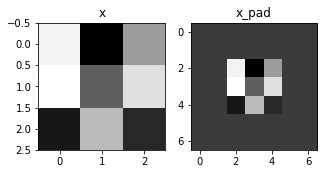

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

print("Shape of x_pad: ", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

**Expected Output**:
<table>
    <tr>
        <td>
            <strong>x_pad.shape</strong>
        </td>
        <td>
            (4,7,7,2)
        </td>
    </tr>

</table>

#### 3.2 - Single step of convolution 

In this part, implement a single step of convolution, in which you apply the filter to a **single position of the input**. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

In [5]:
from scipy import signal
a = np.array([
          [9,3,4,5,7,4],
          [7,6,6,0,3,1],
          [2,7,1,7,8,2],
          [0,8,1,9,0,8],
          [7,6,9,6,1,1],
          [9,0,6,4,9,2]
])
b= np.array([
             [9,3,4],
             [7,6,6],
             [2,7,1]
])

f = np.array([
              [1,0,-1],
              [1,0,-1],
              [1,0,-1]
])
# print(np.sum(np.multiply(b,np.rot90(f,2)))) # Rotating the filter by 180 degrees
# signal.convolve2d(a,f, mode = 'valid') # Convolve function using Sci py

In [6]:
def conv_single_step(a_slice_prev, W, b):
    """
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    """
    # a_slice_prev[...,0]  Gives the first Channel
    Z = np.sum((np.multiply(a_slice_prev,W)))
    return Z + b.reshape(1)[0]

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


**Expected Output**:
<table>
    <tr>
        <td>
            <strong>Z</strong>
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

#### 3.3 - Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

Implement the function below to convolve the filters W on an input activation A_prev. This function takes as input A_prev, the activations output by the previous layer (for a batch of m inputs), F filters/weights denoted by W, and a bias vector denoted by b, where each filter has its own (single) bias. Finally you also have access to the hyperparameters dictionary which contains the stride and the padding. 

For this assignment, we won't worry about vectorization, and will just implement everything with for-loops.

In [8]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
    """
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    ########## START CODE HERE ##########
    # Compute the dimensions of the CONV output volume (Hint: use int() to floor the output)
    n_H = int(((n_H_prev + (2*pad) - f)/stride))+1
    n_W = int(((n_W_prev + (2*pad) - f)/stride))+1
    
    # Initialize the output volume Z with zeros
    Z = np.zeros((m,n_H,n_W,n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    # Iterate over EACH training example and compute its Convolved output (z) and store it appropriately in Z.
    # Hint: Within the nested for loop you need to:
    #              1) Select current training examples appropriate padded activation
    #              2) Identify corner points of the current "slice" 
    #              3) Use these corners to extract a 3D slice from the padded input 
    #              4) Convolve this 3D slice with the appropriate filter and bias to get the output.

    for i in range(m):    
        a_prev_pad =  A_prev_pad[i]
        for h in range(n_H):
          vert_start = h * stride
          vert_end = vert_start + f
            
          for w in range(n_W):
            horiz_start = w * stride
            horiz_end = horiz_start + f
              
            for c in range(n_C):
                  a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                  
                  weights = W[...,c]
                  biases = b[...,c]
                  Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    
    ########## END CODE HERE ##########
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])
Z.shape

Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


(10, 4, 4, 8)

<strong>Expected Output<strong>:

<table>
    <tr>
        <td>
            <strong>Z's mean<strong>
        </td>
        <td>
            0.0489952035289
        </td>
    </tr>
    <tr>
        <td>
            <strong>Z[3,2,1]<strong>
        </td>
        <td>
            [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
        </td>
    </tr>
    <tr>
        <td>
            <strong>cache_conv[0][1][2][3]<strong>
        </td>
        <td>
            [-0.20075807  0.18656139  0.41005165]
        </td>
    </tr>

</table>


**Question**: How would you change the code to apply MaxPooling to the outputs? (Your answer must contain a code snippet and an explanation of its integration with <code>conv_forward</code>)    
Answer: Comments for explanaition are given in the code 

In [0]:
def conv_forward(A_prev, W, b, hparameters, mode):
# Here we will add a mode so if the mode = 'max' then we will apply max pooling otherwise if mode = 'conv' we will simply convolve.
    """
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
    """
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    if mode == 'conv':
      (f, f, n_C_prev, n_C) = W.shape # Since dont need weights here we will keep this for the convolve process only
    
    ########## START CODE HERE ##########
    # Compute the dimensions of the CONV output volume (Hint: use int() to floor the output)
    if mode == 'max': # There is no padding in max pooling as we wish to reduce the size
      n_H = int(1 + (n_H_prev - f) / stride)
      n_W = int(1 + (n_W_prev - f) / stride)
      n_C = n_C_prev # Since there are no filters in max pooling the channels will remain the same as they were in the previos layer
    else:
      n_H = int(((n_H_prev + (2*pad) - f)/stride))+1
      n_W = int(((n_W_prev + (2*pad) - f)/stride))+1

    # Initialize the output volume Z with zeros
    Z = np.zeros((m,n_H,n_W,n_C))
    
    # Create A_prev_pad by padding A_prev
    if mode == 'conv':
      A_prev_pad = zero_pad(A_prev, pad)

    # No padding is required for max pooling as we wish to reduce the size by capturing the significant values
    
    # Iterate over EACH training example and compute its Convolved output (z) and store it appropriately in Z.
    # Hint: Within the nested for loop you need to:
    #              1) Select current training examples appropriate padded activation
    #              2) Identify corner points of the current "slice" 
    #              3) Use these corners to extract a 3D slice from the padded input 
    #              4) Convolve this 3D slice with the appropriate filter and bias to get the output.

    for i in range(m):
      if mode == 'conv':    
        a_prev_pad =  A_prev_pad[i]
      else:
        a_prev = A_prev[i]
        for h in range(n_H):

          vert_start = h * stride
          vert_end = vert_start + f
            
          for w in range(n_W):
            horiz_start = w * stride
            horiz_end = horiz_start + f
              
            for c in range(n_C):
              if mode == 'conv':
                a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                  
                weights = W[...,c]
                biases = b[...,c]
                Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
              else: # Here instead of the need to convolve the slice we need to choose the maximum of the values in the slice and put that in our output
                a_slice_prev = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                Z[i, h, w, c] = np.max(a_slice_prev)

    
    ########## END CODE HERE ##########
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

### 5 - Backpropagation in convolutional neural networks

Brace yourself, you're about to implement backward pass for Convolutional layers using NumPy. Although it is tricky, it will help solidify your concepts a lot before you move on to libraries like TensorFlow which compute the backward pass automatically. You don't have to worry that much since we're providing you with the backpropogation equations (again)

### 5.1 - Convolutional layer backward pass    
<br>

#### 5.1.1 - Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column. Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

#### 5.1.2 - Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the acitivation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

#### 5.1.3 - Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

**Exercise**: Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above.

In [0]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward() cache = (A_prev, W, b, hparameters)
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)                     
    dW = np.zeros(W.shape)  
    db = np.zeros(b.shape)   

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):  
        
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H):
            for w in range(n_W): 
                for c in range(n_C):
                    

                    vert_start = h * stride
                    vert_end = vert_start + f

                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start: vert_end, horiz_start: horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    return dA_prev, dW, db

In [21]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


<strong> Expected Output: <strong>
<table>
    <tr>
        <td>
            <strong>dA_mean<strong>
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            <strong>dW_mean<strong>
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            <strong>db_mean<strong>
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>
